## This does the comparison between fit function and GP fitting on 3.6fb-1 of data and injecting a Gaussian signal based on a fit to our q* samples

In [1]:
%pylab inline --no-import-all

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import george
from george.kernels import MyDijetKernelSimp, ExpSquaredCenteredKernel, SignalKernel


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



## Inputs

In [3]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")


In [4]:
class logLike_gp_test:
    def __init__(self, x, y, xerr, yerr):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.yerr = yerr
    def __call__(self, A, mass, tau, L):
        kernel = A * SignalKernel(m = mass, t = tau, L=L)
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, self.yerr)#0.003)# np.sqrt(abs(self.y)))
            return -gp.lnlikelihood(self.y)
        except:
            print "failed"
            return np.inf  
        
def fit_gp_test(lnprob, Print = True):
    bestval = np.inf
    bestargs = (0, 0, 0, 0)
    passedFit = False
    numRetries = 0
    for i in range(200):
        init0 = np.random.random() * 3.
        init1 = np.random.random() * 3.
        init2 = np.random.random() * 2.
        init3 = np.random.random() * 50.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, errordef = 0.5,
                  A = init0, mass = init1, tau = init2, L = init3,
                  error_A = 0.001, error_mass = 0.001, error_tau = 0.001, error_L =0.001,
                  limit_A = (0.001, 10), limit_mass = (-10, 10), limit_tau = (0.01, 10), limit_L = (0.01, 1000))
        fit = m.migrad()
        #print m.args
        if m.fval < bestval:
            bestval = m.fval
            bestargs = m.args  
            print bestargs

    if Print:
        print "min LL", bestval
        print "best fit vals",bestargs
    return bestval, bestargs

(0.0010104402956859957, 9.462033828148726, 0.8526026856707096, 6.624931117212613)
(2.8346418410588594, 5.269765423160063, 9.302579863989292, 0.1469565444007451)
(1.6252852802854452, 0.0003385763875822789, 0.9367656271621871, 0.10311850477332156)
(1.6271432725263788, 0.00012822779760490732, 0.9367502059249126, 0.10315217482320767)
(1.6282281079313792, -6.048039509209957e-07, 0.9367931498202969, 0.10316695715384641)
A, mass, tau, L 1.62822810793 -6.04803950921e-07 0.93679314982 0.103166957154


/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


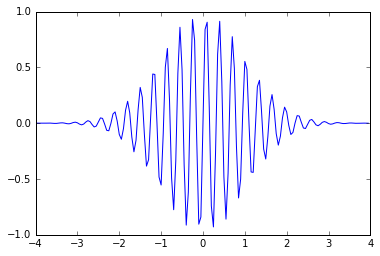

In [5]:

xtoy = np.arange(-4, 4, 0.05)    
xtoy2 = np.arange(-4, 4, 0.01) 
    
signal = np.exp(-(xtoy)**2./2.) * np.sin(20.*xtoy)

plt.plot(xtoy, signal)


lnProb = logLike_gp_test(xtoy, signal, 0.1*np.ones(len(xtoy)), 0.05)
bestval, best_fit_new = fit_gp_test(lnProb, False)
if np.isinf(bestval): 
    print "failed"

        
A, mass, tau, L = best_fit_new 
 
print "A, mass, tau, L", A, mass, tau, L
kernel = A * SignalKernel(m = mass, t = tau, L=L)

gp = george.GP(kernel)
gp.compute(xtoy, 0.05)
meanGP, covGP = gp.predict( signal, xtoy2)




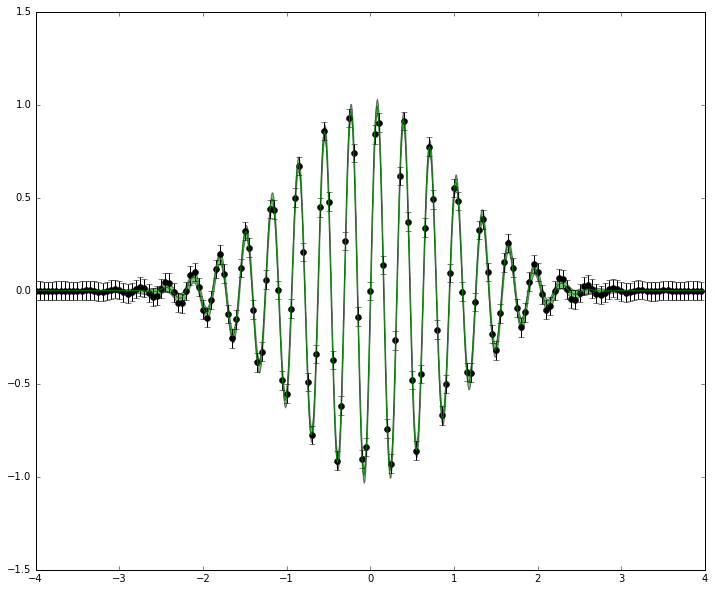

In [6]:
f, ax1 = plt.subplots(1, sharex=True, figsize=(12,10))
ax1.errorbar(xtoy, signal, marker = "o", c= 'black', linestyle = "", yerr = 0.05*np.ones(len(signal)))
ax1.fill_between(xtoy2, meanGP-np.sqrt(np.diag(covGP)), meanGP+np.sqrt(np.diag(covGP)), facecolor='g', alpha=0.5, label="Gaussian Process")
ax1.plot(xtoy2, meanGP, c='green')

(0.16843822325097849, 0.0001356435374404441, 1.008421549366883, 7.043523762370019)
(0.16839128083115404, 5.050239122894595e-06, 1.0084312754195457, 7.035971668118943)
(0.16812433814779393, 3.581576313749224e-06, 1.008443626061297, 7.031736556606209)
(0.16780071259828228, 3.025453210270257e-05, 1.0084738314105135, 7.025853963907933)
(0.16779226610932144, -5.764923667328503e-07, 1.0084637408565553, 7.025647476766036)
(0.1676521886201866, -1.2471074093411971e-06, 1.0084710753614847, 7.0232677553899565)
A, mass, tau, L 0.16765218862 -1.24710740934e-06 1.00847107536 7.02326775539


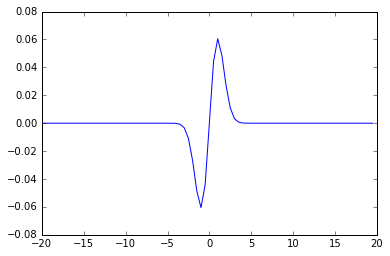

In [16]:

xtoy = np.arange(-20, 20, 0.5)    
xtoy2 = np.arange(-20, 20, 0.01) 
    
signal = np.exp(-(xtoy)**2./2.) * np.sin(0.1*xtoy)
#signal = np.exp(-(xtoy)**2./10.) +0.1*np.sin(xtoy)

plt.plot(xtoy, signal)


lnProb = logLike_gp_test(xtoy, signal, 0.1*np.ones(len(xtoy)), 0.003)
bestval, best_fit_new = fit_gp_test(lnProb, False)
if np.isinf(bestval): 
    print "failed"

        
A, mass, tau, L = best_fit_new 
 
print "A, mass, tau, L", A, mass, tau, L
kernel = A * SignalKernel(m = mass, t = tau, L=L)

gp = george.GP(kernel)
gp.compute(xtoy, 0.05)]
meanGP, covGP = gp.predict( signal, xtoy2)



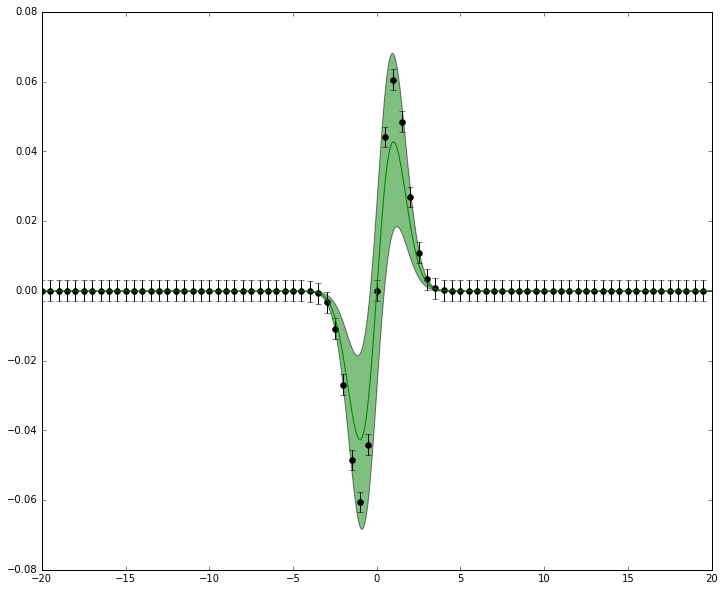

In [17]:
f, ax1 = plt.subplots(1, sharex=True, figsize=(12,10))
ax1.errorbar(xtoy, signal, marker = "o", c= 'black', linestyle = "", yerr = 0.003*np.ones(len(signal)))
ax1.fill_between(xtoy2, meanGP-np.sqrt(np.diag(covGP)), meanGP+np.sqrt(np.diag(covGP)), facecolor='g', alpha=0.5, label="Gaussian Process")
ax1.plot(xtoy2, meanGP, c='green')